In [37]:
import pandas as pd
import networkx as nx
from transliterate import translit
from matplotlib import pyplot as plt
import numpy as np

In [38]:
def transliterate(word):
    return translit(word, "ru", reversed=True)

In [39]:
data = pd.read_csv('data/all.csv', index_col=0)
villages = pd.read_csv('data/villages.csv', index_col=0)

In [40]:
data.shape

(6478, 52)

In [41]:
# match residence in data with village in villages
data = data.merge(villages, left_on='residence', right_on='village', how='left')
data = data.drop(columns=['village'])

In [42]:
data.head(10)

,residence,expedition,name,number of na,russian na,sex,type,year_of_birth,year of death,аварский,...,lon,lang,idiom,republic,region,elevation_y,kutans,comment,elevation_ETOPO1,diff
0,Balkhar,"Balkhar, Tsulikana, Shukty, Kuli",Иса,0,0,м,0,1885.0,1965.0,0.0,...,47.2314,Lak,NaN,Dagestan,NaN,1658.483887,False,NaN,1649.0,9.483887
1,Balkhar,"Balkhar, Tsulikana, Shukty, Kuli",Бет1и,0,0,ж,0,1888.0,1978.0,0.0,...,47.2314,Lak,NaN,Dagestan,NaN,1658.483887,False,NaN,1649.0,9.483887
2,Balkhar,"Balkhar, Tsulikana, Shukty, Kuli",Абдула,0,0,м,0,1890.0,1972.0,1.0,...,47.2314,Lak,NaN,Dagestan,NaN,1658.483887,False,NaN,1649.0,9.483887
3,Balkhar,"Balkhar, Tsulikana, Shukty, Kuli",Патимат,0,0,ж,0,1890.0,1985.0,0.0,...,47.2314,Lak,NaN,Dagestan,NaN,1658.483887,False,NaN,1649.0,9.483887
4,Balkhar,"Balkhar, Tsulikana, Shukty, Kuli",Исмаил,0,0,м,0,1890.0,0.0,1.0,...,47.2314,Lak,NaN,Dagestan,NaN,1658.483887,False,NaN,1649.0,9.483887
5,Balkhar,"Balkhar, Tsulikana, Shukty, Kuli",Жумяъ/Маи,0,0,ж,0,1890.0,1967.0,0.0,...,47.2314,Lak,NaN,Dagestan,NaN,1658.483887,False,NaN,1649.0,9.483887
6,Balkhar,"Balkhar, Tsulikana, Shukty, Kuli",Асият,0,0,ж,0,1893.0,1973.0,0.0,...,47.2314,Lak,NaN,Dagestan,NaN,1658.483887,False,NaN,1649.0,9.483887
7,Balkhar,"Balkhar, Tsulikana, Shukty, Kuli",Айшат,0,0,ж,0,1895.0,1975.0,0.0,...,47.2314,Lak,NaN,Dagestan,NaN,1658.483887,False,NaN,1649.0,9.483887
8,Balkhar,"Balkhar, Tsulikana, Shukty, Kuli",Уди,0,0,ж,0,1895.0,1981.0,0.0,...,47.2314,Lak,NaN,Dagestan,NaN,1658.483887,False,NaN,1649.0,9.483887
9,Balkhar,"Balkhar, Tsulikana, Shukty, Kuli",Амир,1,0,м,0,1900.0,1971.0,0.0,...,47.2314,Lak,NaN,Dagestan,NaN,1658.483887,False,NaN,1649.0,9.483887


In [43]:
len(data['mother tongue'].unique())

29

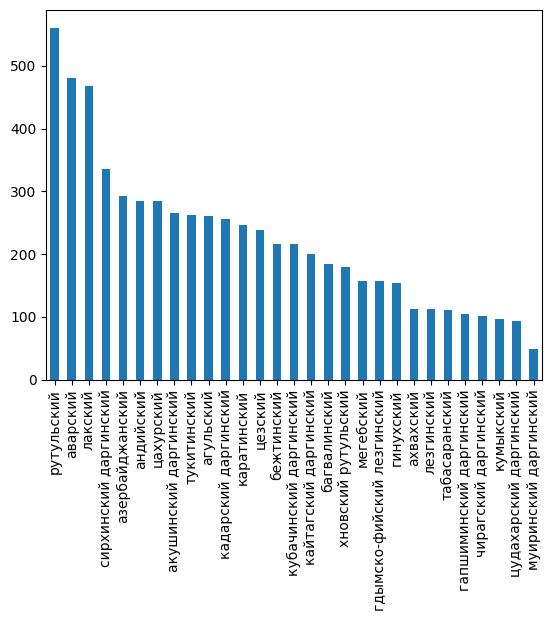

In [44]:
# plot the number of speakers per mother tongue
data['mother tongue'].value_counts().plot(kind='bar')
plt.show()

In [45]:
data.set_index('mother tongue', inplace=True)

In [46]:
matrix = data.loc[:, 'аварский': 'чирагский даргинский']
# only keep columns that are in len(data.index.unique())
matrix = matrix.loc[:, matrix.columns.isin(data.index.unique())]
matrix = matrix.astype(int)
matrix.columns

Index(['аварский', 'агульский', 'азербайджанский', 'акушинский даргинский',
       'андийский', 'ахвахский', 'багвалинский', 'бежтинский',
       'гапшиминский даргинский', 'гдымско-фийский лезгинский', 'гинухский',
       'кадарский даргинский', 'кайтагский даргинский', 'каратинский',
       'кубачинский даргинский', 'кумыкский', 'лакский', 'лезгинский',
       'мегебский', 'муиринский даргинский', 'рутульский',
       'сирхинский даргинский', 'табасаранский', 'тукитинский',
       'хновский рутульский', 'цахурский', 'цезский', 'цудахарский даргинский',
       'чирагский даргинский'],
      dtype='object')

In [47]:
# group by 'mother tongue' and sum
matrix = matrix.groupby(matrix.index).sum()
# turn to percentage
matrix = matrix.div(matrix.sum(axis=1), axis=0)
# add missing languages from columns to index
matrix = matrix.reindex(matrix.columns, axis=0, fill_value=0)
# if column == index, set to 0
matrix = matrix.where(matrix != matrix.T, 0)
# turn Nan to 0
matrix = matrix.fillna(0)

In [48]:
# if less that 5% of speakers speak 
# the language then set the relation to 0
matrix = matrix.where(matrix > 0.05, 0)

In [49]:
# # apply transliteration to index and columns
matrix.index = matrix.index.map(transliterate)
matrix.columns = matrix.columns.map(transliterate)

In [50]:
# convert matrix into a long dataframe with directed edges as rows
df = matrix.stack().reset_index()
df.columns = ['source', 'target', 'weight']
df.head()

# save to csv
df.to_csv('data/edges.csv', index=False)

In [51]:
# convert matrix into a networkx graph
G = nx.from_numpy_array(matrix.values)
# add direction to edges
G = nx.Graph(G)
# set node names
G = nx.relabel_nodes(G, dict(zip(range(len(matrix.columns)), matrix.columns)))

# get pos from G
pos = nx.spring_layout(G, k=1, iterations=5000)

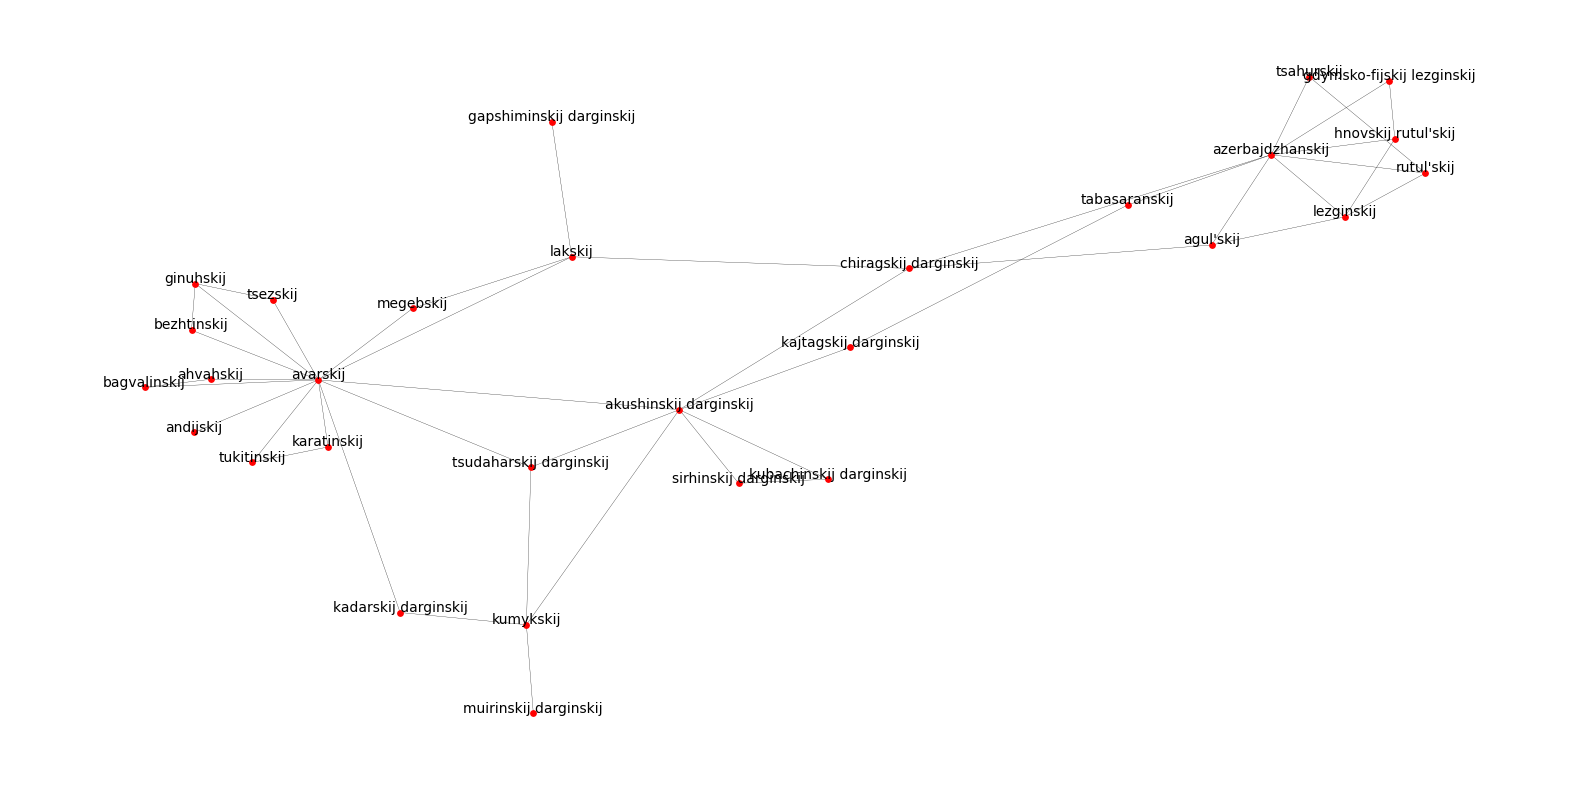

In [30]:
# raise labels above edges
pos_higher = {}
y_off = 0.01  # offset on the y axis
for k, v in pos.items():
    pos_higher[k] = (v[0], v[1] + y_off)

plt.figure(figsize=(20,10))
nx.draw_networkx_edges(G, pos, alpha=1, width=0.2)
nx.draw_networkx_nodes(G, pos, node_size=15, node_color='red')
nx.draw_networkx_labels(G, pos_higher, font_size=10, 
                        font_family='sans-serif', alpha=1)
_ = plt.axis('off')

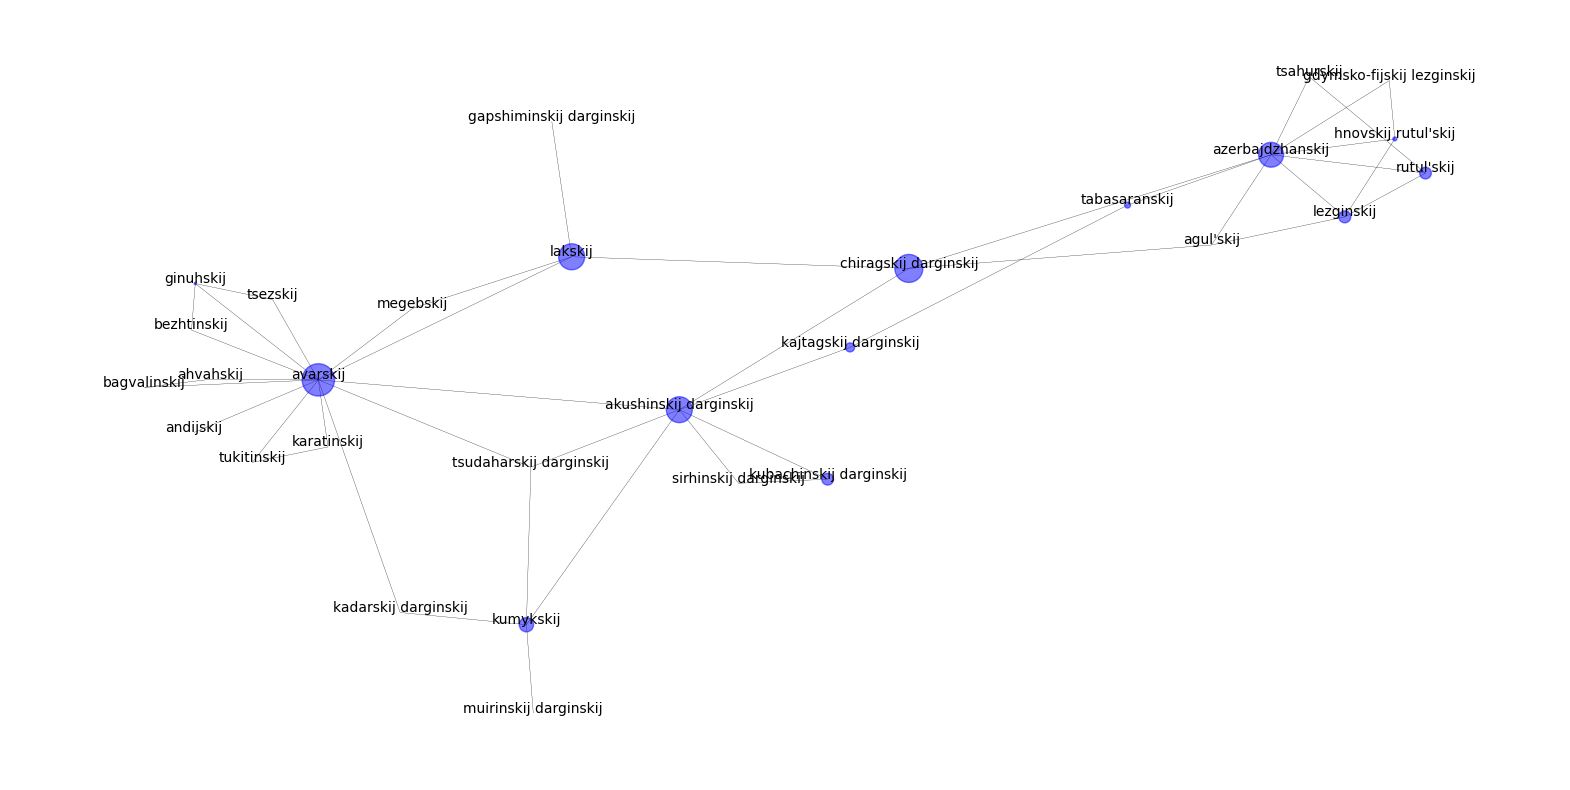

In [31]:
# compute betweenness centrality
betweenness = nx.betweenness_centrality(G, weight='weight')
plt.figure(figsize=(20,10))
nx.draw_networkx_edges(G, pos, alpha=1, width=0.2)
# add nodes without size
nx.draw_networkx_nodes(G, pos, nodelist=betweenness.keys(),
                          node_size=[v * 1000 for v in betweenness.values()],  
                            node_color='blue', alpha=0.5)
nx.draw_networkx_labels(G, pos_higher, font_size=10,
                        font_family='sans-serif', alpha=1)
_ = plt.axis('off')